## Import modules

In [7]:
import tensorflow as tf # pip install tensorflow
from tensorflow import keras # pip install keras
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd # pip install pandas
from gensim.parsing.preprocessing import remove_stopwords # pip install gensim
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np # pip install numpy
import string
from matplotlib import pyplot as plt
import keras_tuner as kt

## Preprocessing

### Load the data

In [8]:
# Load the whole dataset
# Expected execution time: 10s
yelpDataset = pd.read_csv('yelp_dataset_dataset.csv')
yelpDataset.head(5)

,review_id,text,category,votes,order
0,___ISHNflgWKgFvLYzB8Wg,"The difference between ""Red Light Clothing Exc...",funny,7,3
1,___l42spIcSIp4tNhsDgcQ,Tonsof add on fees. Charged me a fuel fee yet ...,useful,7,3
2,___m_sGjAWhFSCAu4n1Bww,"Hormone-free beef. Home fries w/ mozarella, gr...",cool,1,3
3,___Orut5PmmMD5iILAIAFg,"If I were reviewing the non-MD staff here, thi...",useful,15,3
4,___q_rPBSKsPkKH2kvWLEg,"For a department store, Dillards is better tha...",useful,1,3


In [9]:
# Selecting the important columns for this project
reviews = yelpDataset[['text', 'category']]
reviews.head(5)

,text,category
0,"The difference between ""Red Light Clothing Exc...",funny
1,Tonsof add on fees. Charged me a fuel fee yet ...,useful
2,"Hormone-free beef. Home fries w/ mozarella, gr...",cool
3,"If I were reviewing the non-MD staff here, thi...",useful
4,"For a department store, Dillards is better tha...",useful


### Remove stop words

In [10]:
# removing stop words and converting review to lowercase
# Expected execution time: 34m
IsBigram = False
currentIndex = 0
for text, category in reviews.iterrows():
    reviewToLowercase = str(reviews.at[currentIndex,'text']).lower() # converting to lowercase
    reviewWOPunctuation = reviewToLowercase.translate(str.maketrans('', '', string.punctuation)) # remove puncttiation
    reviewWOstopword = remove_stopwords(reviewWOPunctuation) # removing the stop words
    if IsBigram is True:
        reviewBigram = tf.strings.ngrams(
            reviewWOstopword.split(' '),
            2,
            separator='',
            pad_values=None,
            padding_width=None,
            preserve_short_sequences=False,
            name=None
        )
        reviewBigramUnified = ' '.join(e.decode(encoding="utf-8") for e in list(reviewBigram.numpy()))
        reviews.at[currentIndex,'text'] = reviewBigramUnified
    else:
        reviews.at[currentIndex,'text'] = reviewWOstopword


    currentIndex += 1
reviews.head(5)

,text,category
0,difference red light clothing exchange goodwil...,funny
1,tonsof add fees charged fuel fee returned vehi...,useful
2,hormonefree beef home fries w mozarella green ...,cool
3,reviewing nonmd staff easily stars checkin er ...,useful
4,department store dillards better great selecti...,useful


In [11]:
# splitting the dataset into test and train
train_size = 0.6
train_end = int(len(reviews)*train_size)

reviewsTraining = reviews[:train_end]
reviewsTesting = reviews[train_end:]

### Indexing words (Tokenization)

In [12]:
# Transforming the words into ids to speed up computation
# Expected execution time: 3m
tokenizer = Tokenizer(
    num_words = None, # I could set a limit to select the top x most frequent words
    oov_token = "<UNK>" # to replace out-of-vocabulary words during text_to_sequence calls
)

tokenizer.fit_on_texts(list(reviewsTraining['text'])) #introducing words from the training dataset to TF
word_index = tokenizer.word_index # dictionary with words and indexes
print(f"number of words found: {len(word_index)}") # number of words identified

# print some index examples 
count = 0
for word, index in word_index.items():
    print(f"{word}: {index}")
    count += 1
    if count == 10:
        break

number of words found: 418676
<UNK>: 1
place: 2
good: 3
food: 4
like: 5
great: 6
time: 7
service: 8
dont: 9
got: 10


In [13]:
# transforming each review into sequences of tokens/index in the training and testing dataset
# Expected execution time: 6m

def TurnIntoSequence(dataframe: pd.core.frame.DataFrame, startAtIndex: int):
    currentIndex = startAtIndex
    for text, category in dataframe.iterrows():
        reviewToSequence = [dataframe.at[currentIndex,'text']] # Transform each review into a list
        dataframe.at[currentIndex,'text'] = tokenizer.texts_to_sequences(reviewToSequence)[0] # tokenize and [0] is necessary to select the first item returned
        currentIndex += 1
    return dataframe

print("TurnIntoSequence: reviewsTraining")
reviewsTraining = TurnIntoSequence(reviewsTraining, 0)
print("TurnIntoSequence: reviewsTesting")
reviewsTesting = TurnIntoSequence(reviewsTesting, train_end)

TurnIntoSequence: reviewsTraining
TurnIntoSequence: reviewsTesting


In [14]:
# Ensuring that every review/sequence has the same size
# Expected execution time: 2m
LongestReviewSize = 0
currentIndex = 0
sumSize = 0
for text, category in reviewsTraining.iterrows():
    reviewSize = len(reviewsTraining.at[currentIndex,'text'])
    sumSize += reviewSize
    if reviewSize > LongestReviewSize:
        LongestReviewSize = reviewSize
    currentIndex += 1

avgSize = int(sumSize/currentIndex)

print(f"Size of the longest string: {LongestReviewSize} characters") #longest review
print(f"Avg size: {avgSize} characters") #longest review

Size of the longest string: 560 characters
Avg size: 60 characters


In [15]:
# updating the dataframe with strings of same size (process called padding)
# Expected execution time: 4m

def paddingReviews(dataframe: pd.core.frame.DataFrame, startAtIndex: int):
    currentIndex = startAtIndex
    for text, category in dataframe.iterrows():
        reviewPadded = pad_sequences([dataframe.at[currentIndex,'text']], maxlen = avgSize) # create a parsed list
        dataframe.at[currentIndex,'text'] = reviewPadded.tolist()[0] # insert the list into the dataframe
        currentIndex += 1
    return dataframe

print("paddingReviews: reviewsTraining")
reviewsTraining = paddingReviews(reviewsTraining, 0)
print("paddingReviews: reviewsTesting")
reviewsTesting = paddingReviews(reviewsTesting, train_end)

print('Example of final result:')
print(reviewsTraining.at[0,'text'])

paddingReviews: reviewsTraining
paddingReviews: reviewsTesting
Example of final result:
[0, 1179, 335, 381, 1877, 2369, 5299, 1888, 67, 5245, 11, 1716, 6346, 4547, 1877, 161, 821, 1688, 4625, 4625, 14853, 13775, 2285, 295, 127, 2285, 123, 295, 98, 12, 5741, 2791, 5031, 4772, 1307, 2285, 1130, 368, 15, 1589, 7274, 90, 309, 385, 279, 1524, 7275, 12161, 179, 52, 73, 230, 39, 5741, 2380, 105, 1019, 551, 335, 381]


In [16]:
# updating the categories to One-Hot
# Expected execution time: 5m
uniqueCategories = reviewsTraining['category'].unique().tolist()
categoriesDict = {}
count = 0
for item in uniqueCategories:
    categoriesDict[item] = count
    count += 1

def categoriesToOneHot(dataframe: pd.core.frame.DataFrame, startAtIndex: int, categoriesDictionary: dict):
    currentIndex = startAtIndex
    for text, category in dataframe.iterrows():
        categoryString = dataframe.at[currentIndex,'category']
        categoryIndex = categoriesDictionary[categoryString]
        categoryOneHotCode = tf.one_hot(categoryIndex, len(categoriesDictionary), on_value=1)
        categoryOneHotCodeLst = categoryOneHotCode.numpy().tolist()
        dataframe.at[currentIndex,'category'] = categoryOneHotCodeLst
        currentIndex += 1
    return dataframe

reviewsTraining = categoriesToOneHot(dataframe = reviewsTraining, startAtIndex = 0, categoriesDictionary = categoriesDict)
reviewsTesting = categoriesToOneHot(dataframe = reviewsTesting, startAtIndex = train_end, categoriesDictionary = categoriesDict)
reviewsTraining.head()

,text,category
0,"[0, 1179, 335, 381, 1877, 2369, 5299, 1888, 67...","[1, 0, 0]"
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1]"
3,"[2395, 1665, 15379, 31645, 652, 536, 9953, 294...","[0, 1, 0]"
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"


## Model 

In [ ]:
# create the model
# expected execution time: 1m
numberOfCategories = len(categoriesDict)
vocabularySize = len(word_index)

model = tf.keras.Sequential(
    [   
        # avgSize => the lenght of each review padded: 60
        # vocabularySize => the number of different words identified: 418676
        # output_dim => the number of categories (dimensions): 3
        tf.keras.layers.Embedding(input_dim = vocabularySize, output_dim = 3, input_length = avgSize),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.GlobalAveragePooling1D(), 
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)), 
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)), 
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Dense(3, activation='softmax')
        
    ]
)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)



In [ ]:
print("getting training data")
reviewsTrainingSequences = reviewsTraining['text'].to_list()[:10000]
reviewsTrainingCategories = reviewsTraining['category'].to_list()[:10000]
print("getting testing data")
reviewsTestingSequences = reviewsTesting['text'].to_list()[:10000]
reviewsTestingCategories = reviewsTesting['category'].to_list()[:10000]

print("fitting the model")
num_epochs = 50 
history = model.fit(
    reviewsTrainingSequences, 
    reviewsTrainingCategories, 
    epochs = num_epochs, # number of trials
    verbose = 1,  # 1 = progress bar
    validation_data=(reviewsTestingSequences, reviewsTestingCategories),
    workers=3,
    use_multiprocessing=True
    )

#### Validation

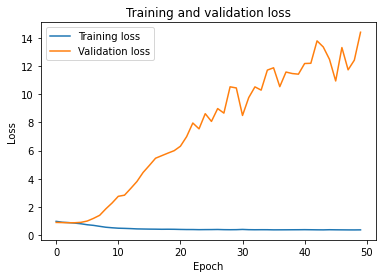

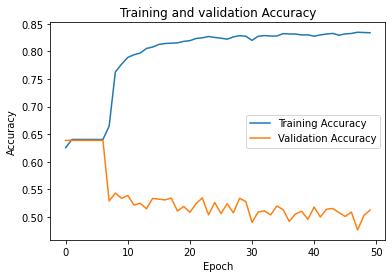

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
 
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label = 'Training loss') #bo for blue dots
plt.plot(val_loss, label = 'Validation loss') #b for blue line
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

plt.plot(acc, label = 'Training Accuracy') #bo for blue dots
plt.plot(val_acc, label = 'Validation Accuracy') #b for blue line
plt.title('Training and validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()